In [1]:
from netCDF4 import Dataset
import numpy as np
# ob type, code and level to read
obtype = 'T'  # temp obs
obcode = 120  # radiosondes
level = 850.  # 850 hPa
# look at contents of file
!ncdump -h prepbufr_2015102700.nc

netcdf prepbufr_2015102700 {
dimensions:
	hdrinfo = 8 ;
	obinfo = 14 ;
	oeinfo = 6 ;
	qcinfo = 7 ;
	nobs = UNLIMITED ; // (706521 currently)
	nmsgs = 8136 ;
	diaginfo = 6 ;
	ensdiaginfo = 6 ;
variables:
	double header(nobs, hdrinfo) ;
		header:_FillValue = 99999997952. ;
		header:desc = "observation header data" ;
		header:SID = "STATION IDENTIFICATION" ;
		header:XOB = "LONGITUDE (DEG E)" ;
		header:YOB = "LATITUDE (DEG N)" ;
		header:DHR = "OBSERVATION TIME MINUS CYCLE TIME (HOURS)" ;
		header:TYP = "PREPBUFR REPORT TYPE" ;
		header:ELV = "STATION ELEVATION (M)" ;
		header:SAID = "SATELLITE IDENTIFIER (SATELLITE REPORTS ONLY)" ;
		header:T29 = "DATA DUMP REPORT TYPE" ;
		header:hdrinfo = "SID XOB YOB DHR TYP ELV SAID T29" ;
	string obid(nobs) ;
		obid:desc = "observation id (station id/type code/lon/lat/time/elevation/pressure)" ;
	float obdata(nobs, obinfo) ;
		obdata:_FillValue = 1.e+11f ;
		obdata:POB = "PRESSURE OBSERVATION (MB)" ;
		obdata:QOB = "SPECIFIC HUMIDITY OBSERVATION (M

In [2]:
# open file
nc = Dataset('prepbufr_2015102700.nc')
# read data
header = nc.variables['header'][:]
press = nc.variables['obdata'][:,0]      # pressure is 1st column of obdata variable (see ncdump above)
obs = nc.variables['obdata'][:,2]        # T observation is 3rd column of obdata
bufrerr = nc.variables['oberr'][:,2]     # T ob error is 3rd column of oberr
gsiges = nc.variables['gsigesdata'][:,1] # T guess value is 2nd column of gsigesdata
gsianl = nc.variables['gsianldata'][:,1] # T anal value is 2nd column of gsianldata
enssprd = nc.variables['gsi_ensstd'][:,1]# T ens spread is 2nd column of gsi_ensstd
used = (nc.variables['gsiqc'][:,1]).astype('bool') # 2nd column of gsiqc is GSI used flag for T ob
# find indices corresponding to specified obcode, pressure level
idx = np.argwhere( \
   np.logical_and( header[:,4] == obcode, \
   np.abs(level-press) <= 1.0) \
   ).squeeze()
idx = np.compress(used[idx],idx) # only select obs used by GSI
print 'number of obs selected = ',len(idx)

number of obs selected =  636


In [3]:
# calculate RMS O-F, O-A and expected value of RMS O-F based on ensemble statistics
print 'RMS ges departure',np.sqrt(np.mean( (obs-gsiges)[idx]**2 ))
print 'expected ges departure',np.sqrt(np.mean( (enssprd**2+bufrerr**2)[idx] ))
print 'RMS anl departure',np.sqrt(np.mean( (obs-gsianl)[idx]**2 ))

RMS ges departure 1.14930534363
expected ges departure 0.934834463619
RMS anl departure 0.832568228245


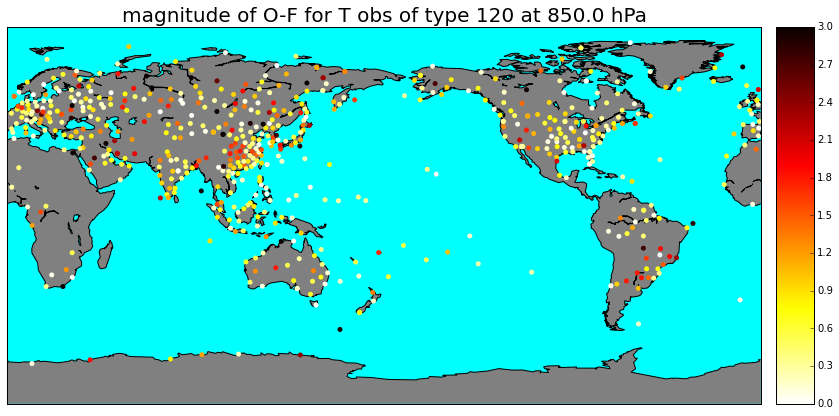

In [4]:
# make map of abs value of guess departures
# show plot inline
%matplotlib inline 
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
lons = header[idx,1]; lats = header[idx,2] # lons and lats are 2nd and 3rd entries in header (see ncdump)
fig = plt.figure(figsize=(16,8))
m = Basemap(lon_0=180)
m.drawcoastlines()
m.fillcontinents(color='grey',lake_color='aqua')
m.drawmapboundary(fill_color='aqua')
m.scatter(lons,lats,25,np.abs(obs-gsiges)[idx],cmap=plt.cm.hot_r,marker='o',\
          vmin=0,vmax=3,edgecolors='none',zorder=10)
m.colorbar()
txt=plt.title('magnitude of O-F for %s obs of type %s at %s hPa' % (obtype, obcode, level),fontsize=20)

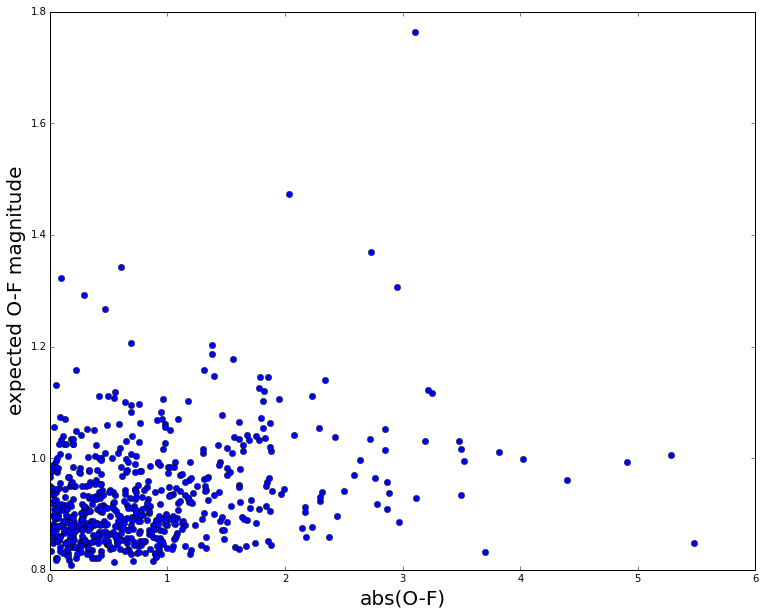

In [23]:
# create scatter plot of expected vs actual O-F magnitude (for data used by GSI)
fig=plt.figure(figsize=(14,10))
p=plt.plot(np.abs(obs-gsiges)[idx],np.sqrt((enssprd**2+bufrerr**2)[idx]),'o')
xlab=plt.xlabel('abs(O-F)',fontsize=20)
ylab=plt.ylabel('expected O-F magnitude',fontsize=20)